<a href="https://colab.research.google.com/github/nanom/textMining2021/blob/main/clustering/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Init and Setting environment

### Install libs

In [1]:
# Install libs
!pip install -U pip setuptools wheel --quiet
!pip install -U spacy[cuda101] --quiet
!python -m spacy download en_core_web_sm --quiet
!pip install contractions --quiet

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 947 kB 31.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 6.0 MB 5.5 MB/s            
     |████████████████████████████████| 628 kB 39.7 MB/s            
     |████████████████████████████████| 181 kB 50.5 MB/s            
     |████████████████████████████████| 451 kB 57.5 MB/s            
     |████████████████████████████████| 42 kB 1.4 MB/s             
     |████████████████████████████████| 10.1 MB 28.8 MB/s            
     |████████████████████████████████| 60.2 MB 11 kB/s              
     |████████████████████████████████| 13.9 MB 105 kB/s            
✔ Download and installation successful
You can now load the packag

### Import and setting

In [2]:
# --- Import libs ---
import spacy
from spacy import displacy
import contractions as ctr

import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

import seaborn as snb
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn import preprocessing, feature_selection, metrics
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.feature_extraction import DictVectorizer

from yellowbrick.cluster import SilhouetteVisualizer

import gensim
from gensim.models import Word2Vec

# --- Acceso a drive ---
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

PATH = "/content/gdrive/MyDrive/Doctorado/cursos_posgrado/textMining2021/clustering/"
SOURCE_FOLDER = PATH + "sources/"
IMG_FOLDER = PATH + "images/"
DF_FOLDER = PATH + "out_dataframes/"

# --- Gral config ---
tqdm.pandas() # Visual pandas proggress

# --- Enable spacy gpu ---
try:
    print("SpaCy GPU available? {}".format(spacy.require_gpu()))
except:
    print("GPU not available. Spacy will work with CPU.")

pln = spacy.load('en_core_web_sm') # Load SpaCy English model

Mounted at /content/gdrive
SpaCy GPU available? True


# 1) Load and preparation of Corpus from VizWiz-VQA dataset

In [ ]:
# Load sets test, val and train
train = pd.read_json(SOURCE_FOLDER+"train.json")
val = pd.read_json(SOURCE_FOLDER+"val.json")
test = pd.read_json(SOURCE_FOLDER+"test.json")

# Show samples
train.head()

,image,question,answers,answer_type,answerable
0,VizWiz_train_00000000.jpg,What's the name of this product?,"[{'answer_confidence': 'yes', 'answer': 'basil...",other,1
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,"[{'answer_confidence': 'yes', 'answer': 'soda'...",other,1
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,"[{'answer_confidence': 'yes', 'answer': 'these...",other,1
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,"[{'answer_confidence': 'yes', 'answer': 't36m'...",other,1
4,VizWiz_train_00000004.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'solar...",other,1


In [ ]:
# Get only questions and merge sets
qs_corpus = pd.concat([train[['question']], val[['question']], test[['question']]])
qs_corpus.reset_index(inplace=True, drop=True)

# Save questions corpus
qs_corpus.to_pickle(DF_FOLDER + 'qs_corpus.pkl')

print("{} questions retrieved!".format(len(qs_corpus)))
qs_corpus.head()

32842 questions retrieved!


,question
0,What's the name of this product?
1,Can you tell me what is in this can please?
2,Is this enchilada sauce or is this tomatoes? ...
3,What is the captcha on this screenshot?
4,What is this item?


# 2) Corpus processing


1.   *Corpus_w_tokens*: Transforms questions to list of tokens.
    * **Q**: "This is a sentence"
    * **Q**: ['this', 'is','a', 'sentence']


2.   *Corpus_w_triplas*: Transforms questions to list of dependencies triplas.

        Ej: ([visual example](https://spacy.io/displacy-3504502e1d5463ede765f0a789717424.svg))
        * **Q**: "This is a sentence"
        * **Triplas**: ['this-nsubj-is' , 'is-ROOT-is', 'a-det-sentence' , 
        'sentence-attr-is']




In [ ]:
# Load corpus of questions
qs_corpus = pd.read_pickle(DF_FOLDER + 'qs_corpus.pkl')

In [ ]:
#  Functions to processing questions of corpus
def qsToTokens(question):
    """
    Transform question to list of tokens (by sentence of question)
    """

    # Expand contractions (ie. what's -> what is)
    question = ctr.fix(question)

    qs_doc = pln(question)

    # Split question in sentences
    qs_sents = [sent for sent in qs_doc.sents]

    # Filter non-alphabetic tokens, lemmatization, pass to lowercase (by each sentence of question)
    tokens_by_sents = []
    for i, sent in enumerate(qs_sents): 
        tokens_list = [ tk.lemma_.lower() for tk in sent if tk.text.isalpha()]
        
        # Add tokens INIT and END to start and end of question
        if i == 0: tokens_list = ['INIT'] + tokens_list
        if i == (len(qs_sents) - 1): tokens_list = tokens_list + ['END']
        
        tokens_by_sents.append(tokens_list)

    return tokens_by_sents


def qsToDepTriplas(question):
    """
    Transform question to list of dependence triplas (by sentence of question)
    Note: In this case, do not add INIT and END tokens to questions.
    """

    # Expand contractions (ie. what's -> what is)
    question = ctr.fix(question)

    qs_doc = pln(question)

    # Filter non-alphabetic tokens, lemmatization, pass to lowercase (by each sentence of question)
    triplas_by_sents = []
    for sent in qs_doc.sents:
        
        # Create list of triplas (tk.lemma_, tk.dep_, ROOT token) 
        triplas_list = [ (tk.lemma_.lower(), tk.dep_, tk.head.lemma_.lower()) 
            for tk in sent if tk.text.isalpha()]
        
        triplas_by_sents.append(triplas_list)

    return triplas_by_sents

#  --- TEST ---
Q1 = "So above these buttons that are here"
Q2 = "Is this enchilada sauce or is this tomatoes?  Thank you."

print("\nQ1: {}".format(Q1))
print("- qs to tokens ->", *qsToTokens(Q1), sep="\n\t")
print("- qs to depTriplas->", *qsToDepTriplas(Q1), sep="\n\t")

print("\nQ2: {}".format(Q2))
print("- qs to tokens ->", *qsToTokens(Q2), sep="\n\t")
print("- qs to depTriplas->", *qsToDepTriplas(Q2), sep="\n\t")


Q1: So above these buttons that are here
- qs to tokens ->
	['INIT', 'so', 'above', 'these', 'button', 'that', 'be', 'here', 'END']
- qs to depTriplas->
	[('so', 'advmod', 'above'), ('above', 'ROOT', 'above'), ('these', 'det', 'button'), ('button', 'pobj', 'above'), ('that', 'nsubj', 'be'), ('be', 'relcl', 'button'), ('here', 'advmod', 'be')]

Q2: Is this enchilada sauce or is this tomatoes?  Thank you.
- qs to tokens ->
	['INIT', 'be', 'this', 'enchilada', 'sauce', 'or', 'be', 'this', 'tomato']
	['thank', 'you', 'END']
- qs to depTriplas->
	[('be', 'ROOT', 'be'), ('this', 'det', 'sauce'), ('enchilada', 'compound', 'sauce'), ('sauce', 'nsubj', 'be'), ('or', 'cc', 'be'), ('be', 'conj', 'be'), ('this', 'det', 'tomato'), ('tomato', 'nsubj', 'be')]
	[('thank', 'ROOT', 'thank'), ('you', 'dobj', 'thank')]


In [ ]:
# Create Corpus_w_tokens (1)
qs_corpus1 = qs_corpus.assign(tokens=qs_corpus.question.progress_apply(lambda qs: qsToTokens(qs)))

# Save 
qs_corpus1.to_pickle(DF_FOLDER+'qs_corpus_w_tokens.pkl')
qs_corpus1.head()

,question,tokens
0,What's the name of this product?,"[[INIT, what, be, the, name, of, this, product..."
1,Can you tell me what is in this can please?,"[[INIT, can, you, tell, i, what, be, in, this,..."
2,Is this enchilada sauce or is this tomatoes? ...,"[[INIT, be, this, enchilada, sauce, or, be, th..."
3,What is the captcha on this screenshot?,"[[INIT, what, be, the, captcha, on, this, scre..."
4,What is this item?,"[[INIT, what, be, this, item, END]]"


In [ ]:
# Create Corpus_w_deptriplas (2)
qs_corpus2 = qs_corpus.assign(tokens=qs_corpus.question.progress_apply(lambda qs: qsToDepTriplas(qs)))

# Save 
qs_corpus2.to_pickle(DF_FOLDER+'qs_corpus_w_deptriplas.pkl')
qs_corpus2.head()

,question,tokens
0,What's the name of this product?,"[[(what, attr, be), (be, ROOT, be), (the, det,..."
1,Can you tell me what is in this can please?,"[[(can, aux, tell), (you, nsubj, tell), (tell,..."
2,Is this enchilada sauce or is this tomatoes? ...,"[[(be, ROOT, be), (this, det, sauce), (enchila..."
3,What is the captcha on this screenshot?,"[[(what, attr, be), (be, ROOT, be), (the, det,..."
4,What is this item?,"[[(what, attr, be), (be, ROOT, be), (this, det..."


# 3) Vocabulary

### Generation

In [ ]:
# Load corpus_w_tokens
qs_corpus = pd.read_pickle(DF_FOLDER + 'qs_corpus_w_tokens.pkl')

In [ ]:
# Get all tokens from each questions
tokens_list = [tk for qs_sents in qs_corpus.tokens.to_list() for sent in qs_sents for tk in sent]

# Create vocab of word and frequences
vocab_dic = Counter(tokens_list)

print("- There are a total of {} words (lemmas) in the corpus!".format(len(tokens_list)))
print("- The vocabulary consist of {} uniques words!,".format(len(vocab_dic)))

# Convert in dataframe and save
vocab_df = pd.DataFrame.from_dict(vocab_dic, orient='index').reset_index()
vocab_df.rename(columns={'index':'word',0:'freq'}, inplace=True)
vocab_df.sort_values(by=['freq'], ascending=False, inplace=True)
vocab_df = vocab_df.reset_index(drop=True)
vocab_df.to_pickle(DF_FOLDER+"vocab.pkl")

- There are a total of 289946 words (lemmas) in the corpus!
- The vocabulary consist of 3888 uniques words!,


### Análisis

In [ ]:
# Cargo vocabulario
vocab = pd.read_pickle(DF_FOLDER+"vocab.pkl")

Top word in corpus

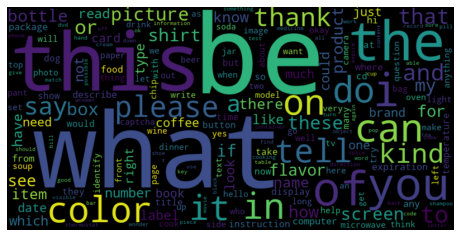

In [ ]:
# Top most frequents word (without INIT and END tokens)

data = vocab.set_index('word').to_dict()['freq']
top = 200
data.pop('INIT')
data.pop('END')

wc = WordCloud(width=800, height=400, max_words=top).generate_from_frequencies(data)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Word frequency distributions

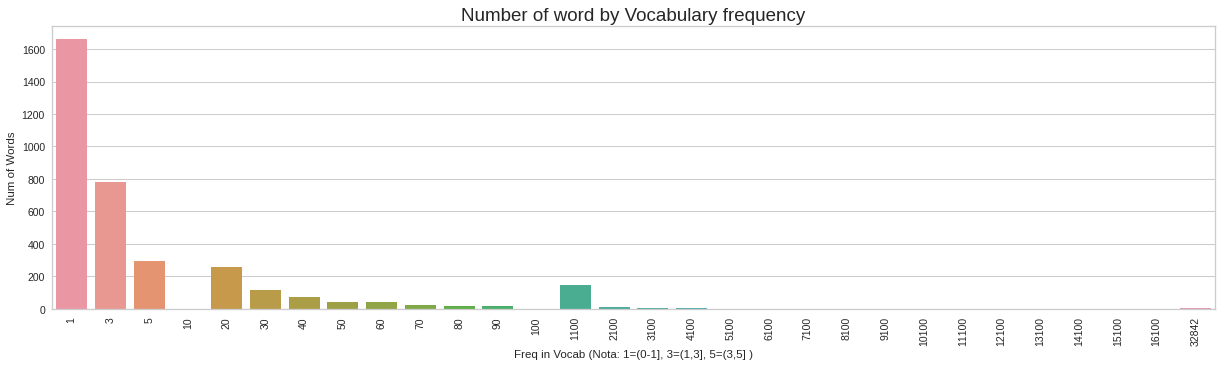

In [ ]:
max_freq = vocab.iloc[0].freq
freq_dic = {}

# Number of words with frequencies in the range  (0,1]
freq_dic[1] = len(vocab[(vocab.freq > 0) & (vocab.freq <= 1)])

# Number of words with frequencies in the range  (1,3]
init_range = 1; end_range = 3
freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])

# Number of words with frequencies in the range  (3,5]
init_range = 3; end_range = 5
freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])

# Number of words with frequencies in the range  (5,10]
init_range = 5; end_range = 10
freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])

# Number of words with frequencies in the range  (10, 100]
init_range = 10; end_range = 100
for end_range in range(init_range, end_range+1, 10):
    freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])
    init_range = end_range

# Number of words with frequencies in the range  (100, len(vocab/2)]
init_range = 100; end_range = int(max_freq / 2)
for end_range in range(init_range, end_range+1, 1000):
    freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])
    init_range = end_range

# Number of words with frequencies in the range  (len(vocab)/2, len(vocab)]
init_range = int(max_freq / 2); end_range = max_freq
freq_dic[end_range] = len(vocab[(vocab.freq > init_range) & (vocab.freq <= end_range)])

# Plot
freq_dic_df = pd.DataFrame.from_dict(freq_dic, orient='index').reset_index()
freq_dic_df.rename(columns={'index':'freq',0:'num_words'}, inplace=True)
freq_dic_df.sort_values(by=['freq'], ascending=True, inplace=True)

plt.figure(figsize=(20,5), dpi=75)
g = snb.barplot(data=freq_dic_df, y='num_words', x='freq')
g.set_ylabel("Num of Words")
g.set_xlabel("Freq in Vocab (Nota: 1=(0-1], 3=(1,3], 5=(3,5] )")
plt.xticks(rotation=90)
plt.title("Number of word by Vocabulary frequency", fontsize=18)
plt.show()

Top 100 most frequent words distribution

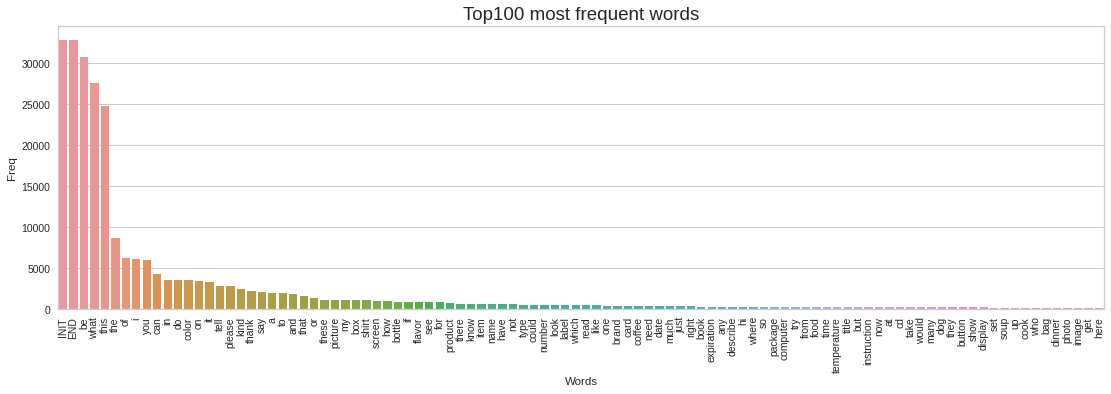

In [ ]:
bar_width = .18 # Histogram bar width
top_words = 100

plt.figure(figsize=(bar_width*top_words,5), dpi=75)
g = snb.barplot(data=vocab[:top_words], x='word', y='freq')
g.set_xlabel("Words")
g.set_ylabel("Freq")
plt.xticks(rotation=90)
plt.title("Top{} most frequent words".format(str(top_words)), fontsize=18)
plt.show()

Top 51-150 most frequent words distribution

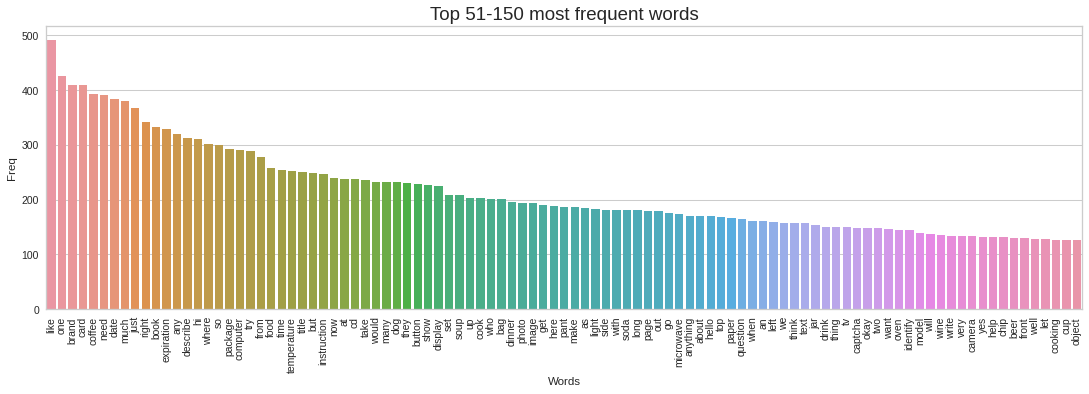

In [ ]:
start = 51
end = 150
plt.figure(figsize=((end-start)*bar_width,5), dpi=75)
g = snb.barplot(data=vocab[start:end], x='word', y='freq')
g.set_xlabel("Words")
g.set_ylabel("Freq")
plt.xticks(rotation=90)
plt.title("Top {}-{} most frequent words".format(str(start),str(end)), fontsize=18)
plt.show()

# 4) Vectorization

In [ ]:
# Load vocabulary dataframe
vocab = pd.read_pickle(DF_FOLDER+'vocab.pkl')

## 4.1) By Co-ocurrence Matrix

### Using words correlation


*   Window size = [1,2 or 4]
*   Context: Sentence of each question



In [ ]:
# Load corpus with tokens
qs_corpus_w_tokens = pd.read_pickle(DF_FOLDER+"qs_corpus_w_tokens.pkl")

In [ ]:
def genCooMatrix_wc(vocab, qs_corpus, window_size=2, debug=False):

    # Get word id from word string
    word2Id = lambda w: vocab[vocab.word == w].index.values[0]

    # Init Coo Matrix NxN (N = lenght of vocabulary)
    N = len(vocab)
    coo_matrix = np.zeros((N,N))

    print("Proccess [window_size={}] ...".format(window_size))
    for qs_sents in tqdm(qs_corpus.tokens):
        if debug: print("\n* ", *qs_sents, sep=" ")
        for sent in qs_sents:
            for tk_pos, token in enumerate(sent):
                start = max(0, tk_pos - window_size)
                end = min(len(sent), tk_pos + window_size)
                for co_token in sent[start:end + 1]:
                    if token != co_token:
                        if debug: print("{}-{}".format(token, co_token), end=", ")
                        coo_matrix[word2Id(token)][word2Id(co_token)] += 1

    return pd.DataFrame(coo_matrix)

# -- TEST --
coo_matrix = genCooMatrix_wc(vocab, qs_corpus_w_tokens[:3], 2, debug=True)

Proccess [window_size=2] ...


 67%|██████▋   | 2/3 [00:00<00:00, 12.42it/s]


*  ['INIT', 'what', 'be', 'the', 'name', 'of', 'this', 'product', 'END']
INIT-what, INIT-be, what-INIT, what-be, what-the, be-INIT, be-what, be-the, be-name, the-what, the-be, the-name, the-of, name-be, name-the, name-of, name-this, of-the, of-name, of-this, of-product, this-name, this-of, this-product, this-END, product-of, product-this, product-END, END-this, END-product, 
*  ['INIT', 'can', 'you', 'tell', 'i', 'what', 'be', 'in', 'this', 'can', 'please', 'END']
INIT-can, INIT-you, can-INIT, can-you, can-tell, you-INIT, you-can, you-tell, you-i, tell-can, tell-you, tell-i, tell-what, i-you, i-tell, i-what, i-be, what-tell, what-i, what-be, what-in, be-i, be-what, be-in, be-this, in-what, in-be, in-this, in-can, this-be, this-in, this-can, this-please, can-in, can-this, can-please, can-END, please-this, please-can, please-END, END-can, END-please, 
*  ['INIT', 'be', 'this', 'enchilada', 'sauce', 'or', 'be', 'this', 'tomato'] ['thank', 'you', 'END']
INIT-be, INIT-this, be-INIT, be-thi

100%|██████████| 3/3 [00:00<00:00, 12.15it/s]

tomato-be, tomato-this, thank-you, thank-END, you-thank, you-END, END-thank, END-you, 

In [ ]:
# Generate co-ocurrence matrix using a windos_size = 2.
coo_matrix = genCooMatrix_wc(vocab, qs_corpus_w_tokens, 2)

# Save
coo_matrix.to_pickle(DF_FOLDER+"coo_matrix_w2.pkl")

### Using triplas of dependency

Ej: ([visual example](https://spacy.io/displacy-3504502e1d5463ede765f0a789717424.svg))
* **Q**: "This is a sentence"
* **Triplas**: ['this-nsubj-is' , 'is-ROOT-is', 'a-det-sentence' , 
'sentence-attr-is']

In [ ]:
# Load corpus with triplas of dependency
qs_corpus_w_deptriplas = pd.read_pickle(DF_FOLDER+'qs_corpus_w_deptriplas.pkl')

def dropSpecialTokens(vocab):
    "Delete INIT and END tokens in vocab"

    # Delete INIT and END token in vocab
    vocab = vocab.drop(0)
    vocab = vocab.drop(1)
    vocab = vocab.reset_index(drop=True)
    return vocab

In [ ]:
def genCooMatrix_wtripla(vocab, qs_corpus, filter_triplas_freq=10, debug=False):

    # Delete te INIT and END token in vocab
    vocab = dropSpecialTokens(vocab)

    # Get word id from word string
    word2Id = lambda w: vocab[vocab.word == w].index.values[0]

    # Init dic of triples by id_word and triplas frequency
    word_id_dic = {wid: {} for wid in vocab.index}
    triplas_frequency = Counter([l+"-"+d+"-"+h for sents in qs_corpus.tokens.to_list() for sent in sents for l,d,h in sent])
    
    for sents in tqdm(qs_corpus.tokens):
        for sent in sents:
            if debug: print("\n* ", sent)
            for lemma,dep,head in sent:
                t_str = lemma+"-"+dep+"-"+head
                # Only add triplas that occurre at least 10 times
                if triplas_frequency[t_str] >= filter_triplas_freq or debug:
                    triplas = word_id_dic[word2Id(lemma)]
                    triplas[t_str] = triplas.get(t_str, 0) + 1
    
    if debug:
        print("\nExample of Dic of triplas generated:")
        for k,v in word_id_dic.items():
            if len(v) > 0:
                print(k,"->", v)

    # Convert dic of triplas_dic to list of triplas_dic
    list_of_triplas_dic = word_id_dic.values()

    # Transform to vector
    vectorized = DictVectorizer(sparse=False)
    coo_matrix = vectorized.fit_transform(list_of_triplas_dic)

    return pd.DataFrame(coo_matrix)

# -- TEST --
coo_matrix = genCooMatrix_wtripla(vocab, qs_corpus_w_deptriplas[2:4], debug=True)

100%|██████████| 2/2 [00:00<00:00, 113.35it/s]


*  [('be', 'ROOT', 'be'), ('this', 'det', 'sauce'), ('enchilada', 'compound', 'sauce'), ('sauce', 'nsubj', 'be'), ('or', 'cc', 'be'), ('be', 'conj', 'be'), ('this', 'det', 'tomato'), ('tomato', 'nsubj', 'be')]

*  [('thank', 'ROOT', 'thank'), ('you', 'dobj', 'thank')]

*  [('what', 'attr', 'be'), ('be', 'ROOT', 'be'), ('the', 'det', 'captcha'), ('captcha', 'nsubj', 'be'), ('on', 'prep', 'captcha'), ('this', 'det', 'screenshot'), ('screenshot', 'pobj', 'on')]

Example of Dic of triplas generated:
0 -> {'be-ROOT-be': 2, 'be-conj-be': 1}
1 -> {'what-attr-be': 1}
2 -> {'this-det-sauce': 1, 'this-det-tomato': 1, 'this-det-screenshot': 1}
3 -> {'the-det-captcha': 1}
6 -> {'you-dobj-thank': 1}
11 -> {'on-prep-captcha': 1}
16 -> {'thank-ROOT-thank': 1}
22 -> {'or-cc-be': 1}
126 -> {'captcha-nsubj-be': 1}
294 -> {'sauce-nsubj-be': 1}
573 -> {'tomato-nsubj-be': 1}
1262 -> {'screenshot-pobj-on': 1}
1457 -> {'enchilada-compound-sauce': 1}


In [ ]:
# Generate co-ocurrence matrix of dependency triples
coo_matrix = genCooMatrix_wtripla(vocab, qs_corpus_w_deptriplas, 5)

# Save
coo_matrix.to_pickle(DF_FOLDER+"coo_matrix_triplas.pkl")

100%|██████████| 32842/32842 [02:35<00:00, 211.32it/s]


### Normalization + Dimensionality reduction

In [ ]:
def normAndReduction(coo_matrix,  threshold_var= .001, reduction=True):

    # Normalization by examples due the distribution of frequency words is exponential
    matrix = preprocessing.normalize(coo_matrix, axis=1, norm='l2')
    print("Coo-Matrix dimensionality post Normalization: {}".format(coo_matrix.shape))

    if reduction:
        # Decrease in dimensionality by variance threshold. That is: I remove features (columns) 
        # with very low variability (less than 'threshold_var').
        selector = feature_selection.VarianceThreshold(threshold_var)
        matrix = selector.fit_transform(matrix)

        print("Post (Norm + Dimensionality reduction): {}".format(matrix.shape))

    # Convert to dataframe y return
    return pd.DataFrame(matrix)

In [ ]:
# Load coo_matrix dataframe
coo_matrix = pd.read_pickle(DF_FOLDER + "coo_matrix_w1.pkl")
# coo_matrix = pd.read_pickle(DF_FOLDER + "coo_matrix_triplas.pkl")


# Execute normalization and dimensionality recuction
features = normAndReduction(coo_matrix, threshold_var=.001)
# features = normAndReduction(coo_matrix, threshold_var=.001, reduction=False)

# Save features
features.to_pickle(DF_FOLDER+"features_w1.pkl")
# features.to_pickle(DF_FOLDER+"features_triplas.pkl")
features

Coo-Matrix dimensionality post Normalization: (3888, 3888)
Post (Norm + Dimensionality reduction): (3888, 73)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
0,0.000000,0.000000,0.074677,0.991964,0.012767,0.003642,0.000043,0.022750,0.001200,0.087573,0.001628,0.018637,0.002014,0.000943,0.002314,0.004541,0.016838,0.001414,0.000343,0.000257,0.000214,0.000814,0.000428,0.000000,0.000300,0.000771,0.000043,0.000171,0.000129,0.024721,0.001071,0.000300,0.003513,0.001414,0.000643,0.000171,0.000214,0.000514,0.012596,0.000000,0.000471,0.000043,0.000171,0.001242,0.000257,0.000043,0.000514,0.001285,0.000728,0.000043,0.000000,0.000000,0.000043,0.000000,0.000086,0.000043,0.000000,0.000557,0.000043,0.000043,0.000086,0.000086,0.000043,0.000043,0.000771,0.000000,0.000043,0.000000,0.000043,0.000043,0.000043,0.000000,0.000000
1,0.000000,0.000000,0.077649,0.001549,0.944375,0.003389,0.030982,0.017234,0.161979,0.067677,0.001743,0.004841,0.013652,0.012490,0.099627,0.000871,0.122089,0.027981,0.129641,0.001065,0.008133,0.000581,0.045795,0.000387,0.041439,0.000290,0.067289,0.066321,0.042407,0.000000,0.000194,0.003970,0.010650,0.003292,0.003582,0.002130,0.008230,0.001259,0.000484,0.012683,0.004744,0.010263,0.003582,0.000097,0.005809,0.017137,0.000290,0.000290,0.006100,0.003389,0.000097,0.004260,0.008714,0.000387,0.004357,0.003001,0.004066,0.007165,0.000194,0.001259,0.000581,0.002130,0.000194,0.000871,0.001355,0.000581,0.000775,0.002324,0.000000,0.000678,0.000484,0.001162,0.000678
2,0.075756,0.034857,0.000000,0.647816,0.716227,0.133779,0.000608,0.035596,0.005563,0.004911,0.100704,0.001521,0.122696,0.043680,0.088578,0.000478,0.011213,0.001347,0.001217,0.020688,0.004216,0.007867,0.041811,0.003955,0.038552,0.021471,0.001956,0.003781,0.000652,0.001087,0.000695,0.015603,0.001521,0.023296,0.000782,0.007128,0.005650,0.002825,0.002130,0.000391,0.004259,0.004086,0.010562,0.002869,0.000695,0.003651,0.001869,0.001130,0.001521,0.004607,0.000522,0.000782,0.000478,0.000043,0.005346,0.001521,0.000522,0.001478,0.000739,0.000739,0.000087,0.000217,0.002086,0.000695,0.001087,0.000869,0.000304,0.001087,0.000522,0.000435,0.000087,0.000869,0.000000
3,0.827799,0.000572,0.532905,0.000000,0.026172,0.014838,0.001144,0.064892,0.002467,0.003861,0.000215,0.071185,0.110121,0.000358,0.005506,0.008795,0.000644,0.000000,0.001251,0.000107,0.000322,0.013265,0.001251,0.002288,0.001251,0.000787,0.000822,0.000679,0.000322,0.000072,0.000072,0.024741,0.000322,0.000143,0.000286,0.000322,0.001788,0.000036,0.000072,0.000179,0.000072,0.001680,0.000286,0.000143,0.000536,0.002074,0.000107,0.001609,0.000107,0.003969,0.001001,0.000000,0.000143,0.000000,0.000679,0.000393,0.000000,0.000036,0.000072,0.000036,0.000000,0.001037,0.000036,0.000036,0.000072,0.000036,0.000107,0.000036,0.000000,0.000000,0.000036,0.000072,0.000000
4,0.015226,0.498368,0.841973,0.037401,0.000000,0.001890,0.055845,0.001533,0.000255,0.046087,0.126763,0.073779,0.005518,0.072962,0.000358,0.000204,0.020846,0.000613,0.029992,0.017883,0.001533,0.008328,0.001380,0.000358,0.000051,0.001124,0.041335,0.032649,0.006847,0.000204,0.007868,0.003525,0.009401,0.000102,0.002452,0.000051,0.000817,0.002248,0.000051,0.000409,0.003832,0.010679,0.002759,0.000102,0.001380,0.009657,0.000153,0.000409,0.001737,0.001839,0.000358,0.000000,0.000971,0.000000,0.000000,0.001022,0.000102,0.000204,0.000000,0.000971,0.002248,0.002452,0.000715,0.000000,0.000102,0.000000,0.000102,0.000971,0.000000,0.000664,0.000153,0.000102,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

## 4.2) By Word Embedding Neuronales (Word2Vec)

In [ ]:
# Function to generate and save features, using Word2Vec lib
def myWord2Vec(qs_corpus, vocab, window_size=5, vector_size=100, sents_len=None):

    # Get tokens list by context (Only qs with 0ne sents)
    if sents_len != None:
        data = [sent for sents in qs_corpus.tokens.to_list() for sent in sents if len(sents) <= sents_len]

    else:
        data = [sent for sents in qs_corpus.tokens.to_list() for sent in sents]

    # Create CBOW model
    model = gensim.models.Word2Vec(data, size=vector_size, window=window_size, min_count=1)

    #  Embedding for each word
    embedding_list = []
    for word in model.wv.vocab:
        embedding_list.append(model.wv[word])

    embedding = pd.DataFrame(embedding_list)

    # Normalization
    features = preprocessing.normalize(embedding, axis=1, norm='l2')

    # Convert to df and save
    features = pd.DataFrame(features)
    features.to_pickle(DF_FOLDER+"word2vec_w{}_v{}.pkl".format(window_size, vector_size))

    if sents_len != None:
        # Fix vocabulary words, due to the elimination of questions with more than one sentence 
        vocab = vocab[vocab.word.isin(model.wv.vocab.keys())]

    return vocab, features

In [ ]:
new_vocab, features = myWord2Vec(qs_corpus, vocab, window_size=1, vector_size=100, sents_len=1)

# Clustering

### Useful functions

In [ ]:
# Load vocab
vocab = pd.read_pickle(DF_FOLDER+'vocab.pkl')

In [ ]:
# Funciones para crear y mostrar resultados de clusterizacion
def myKmeans(features, k):
    """
    Search clusters using Kmenas method
    """
    k_cluster = k
    km_model = KMeans(n_clusters=k_cluster,  max_iter=600, n_init=5)
    km_model.fit(features)
    
    print(Counter(km_model.labels_))
    return km_model

def plotKmeansResults(km_model, features, vocab, top_words=50):
    """
    Generate siluhuette and clusters 2D plots (side by side)
    Return:
        Dataframe with the 'top_words' most frecuence in vocabulary by each clusters
    """

    # Config grides
    fig, ax = plt.subplots(1, 2, figsize=(25, 10))

    # --- Plot Silhouette ---
    visualizer = SilhouetteVisualizer(km_model,  colors='yellowbrick', ax=ax[0])
    visualizer.fit(features) # Fit the data to the visualizer
    
    # --- PLot 2d clusters using t-SNE ---
    x_embedded = TSNE(n_components=2).fit_transform(features)
    
    # Conver to dataframe
    cluster_df = pd.DataFrame(x_embedded) 
    cluster_df = cluster_df.assign(label=km_model.labels_, word=vocab.word, freq=vocab.freq)
    
    # Take the topN most frequent words (according to vocabulary) by cluster
    cluster_df.sort_values(['label','freq'], ascending=False, inplace=True)
    top_words_by_cluster = cluster_df.groupby('label').head(top_words)

    snb.scatterplot(data= top_words_by_cluster, x=0,y=1, hue='label', palette='tab20', ax=ax[1])
    plt.legend(markerscale=2)
    plt.show()

    return top_words_by_cluster 

def printWordByCluster(km_model, top_words_by_cluster, top=20):
    """
    Print a list of top_word most frecunt by cluster.
    """

    for c in range(0, km_model.n_clusters):
        print("\nCluster {} - Top {} most freq words:\n------".format(c, top))
        ws = top_words_by_cluster[top_words_by_cluster.label == c]
        for j,w in enumerate(ws.head(top).word.to_list()):
            print("{}".format(w), end=", ")
            if (j % 15 == 0 and j > 0):
                print("")
        print("")

# TODO
# def printWordByClusterDistance(km_model, features, vocab, top=20):
#     # Calculo distancias entre las palabras y los centros de cada cluster
#     X = euclidean_distances(features, km_model.cluster_centers_)
#     for c in range(0, km_model.n_clusters):
#         print("\nCluster {} - Top {} most freq words:\n------".format(c, top))
#         w_ids = vocab.iloc[model.labels_ == c].index
#         w_distance = X[w_ids][:,c]
#         top_words = [id2Word(w_id) for w_id,_ in sorted(tuple(zip(w_ids, w_distance)), key=lambda x: x[1]) ]

#         for j,w in enumerate(top_words[:top]):
#             print("{}".format(w), end=", ")
#             if (j % 15 == 0 and j > 0):
#                 print("")
#         print("")

### Results using co-ocurrence Matrixs

##### Features with Word Correlation (WINDOW_SIZE=1) 

Counter({12: 601, 16: 335, 1: 298, 6: 292, 4: 291, 11: 270, 7: 261, 3: 230, 9: 201, 19: 173, 2: 163, 10: 126, 5: 116, 8: 101, 0: 96, 13: 90, 15: 83, 18: 74, 17: 47, 14: 40})


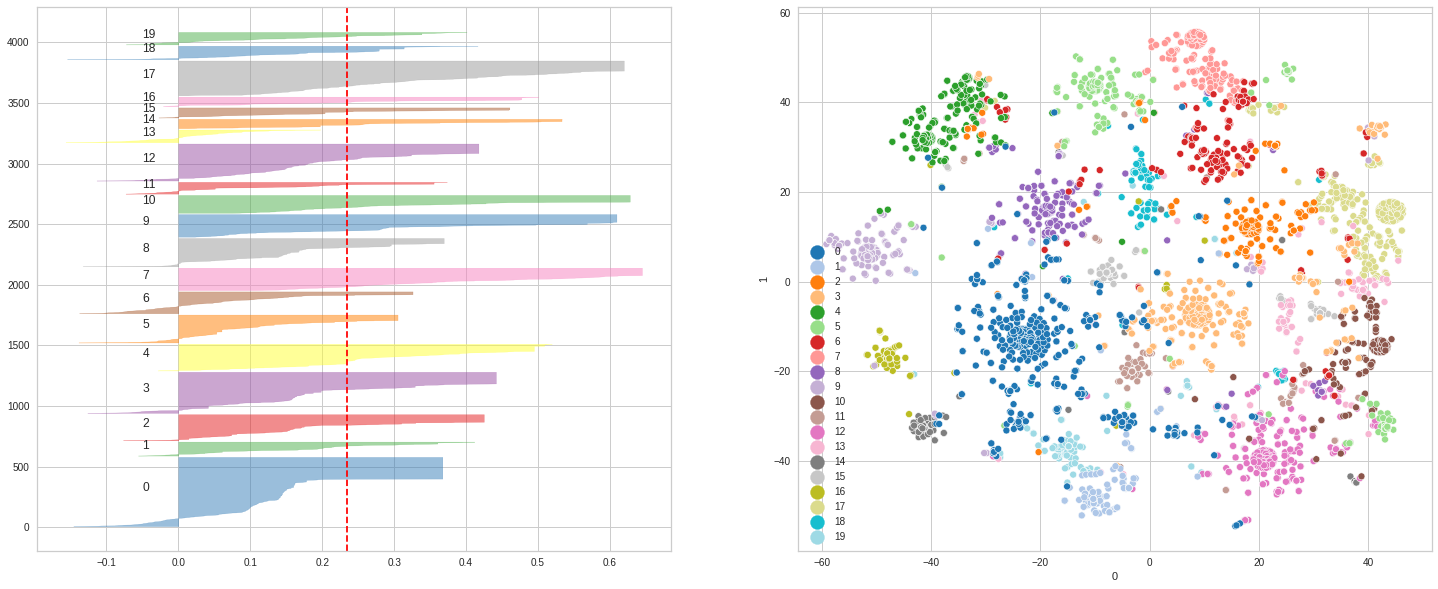

In [ ]:
# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'features_w1.pkl')

model = myKmeans(features=features, k=20)
top_words_by_cluster = plotKmeansResults(model, features, vocab, top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=100)


Cluster 0 - Top 100 most freq words:
------
thank, to, see, look, any, many, as, long, we, very, sure, possible, down, your, someone, more, 
gift, far, mile, digit, error, pot, dollar, specific, anyone, morning, storm, web, worker, sunny, somebody, 
street, mountain, id, even, baseball, flash, anybody, cooker, per, quite, her, potter, harry, maker, favorite, 
hole, trouble, eight, between, least, rain, engine, count, fully, nothing, update, hp, measure, example, indicate, 
along, double, blu, issue, speak, holder, choice, equal, casual, shut, combination, safe, ink, once, colored, 
rose, properly, vibrate, bless, purpose, while, cider, mini, s, football, never, soy, without, perhaps, recognize, 
complete, clearly, moldy, daylight, site, direct, puffy, balm, self, 

Cluster 1 - Top 100 most freq words:
------
know, right, try, set, go, left, want, find, able, way, leave, determine, point, figure, start, close, 
boot, suppose, win, talk, wait, enough, seem, appear, around, next, focus, 

##### Features with Word Correlation (WINDOW_SIZE=2)

Counter({7: 393, 1: 315, 12: 304, 10: 300, 8: 298, 13: 289, 11: 277, 0: 266, 9: 265, 4: 239, 3: 235, 5: 230, 6: 201, 2: 159, 14: 117})


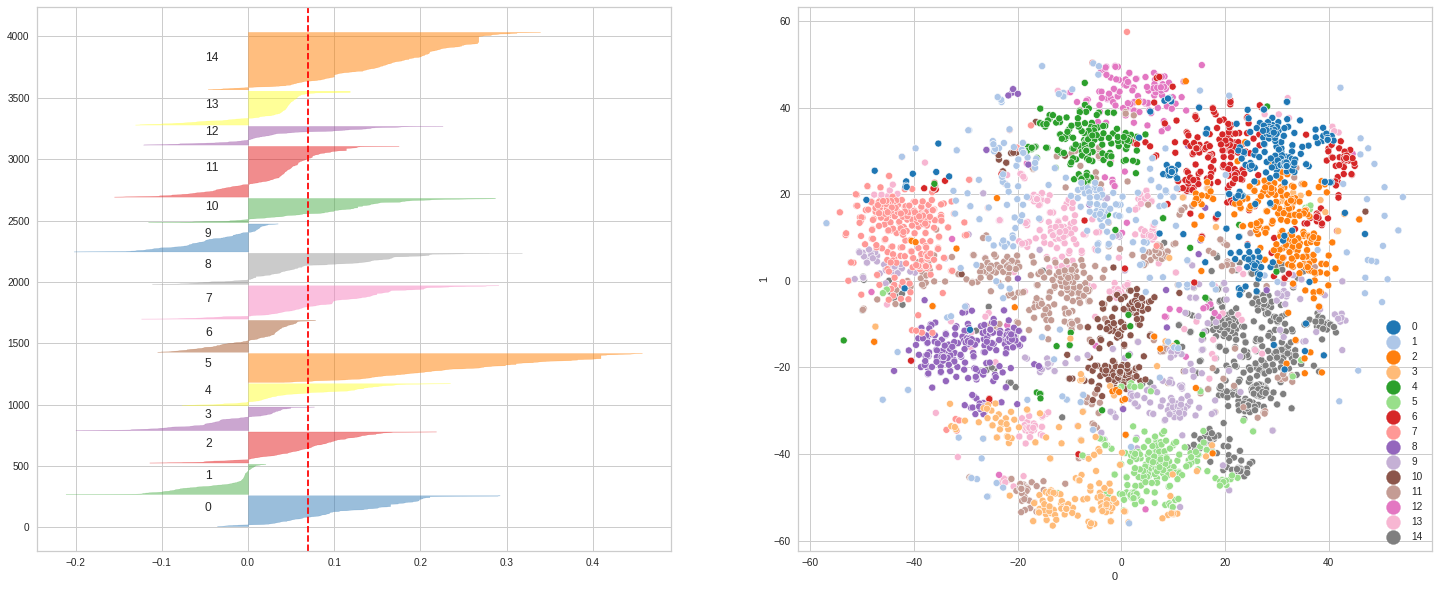

In [ ]:
# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'features_w2.pkl')

model = myKmeans(features=features, k=15)
top_words_by_cluster = plotKmeansResults(model, features, vocab, top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=50)


Cluster 0 - Top 50 most freq words:
------
screen, date, right, expiration, now, at, show, microwave, question, off, table, wall, window, bottom, setting, outside, 
start, floor, digit, iphone, door, glass, shelf, clock, serve, open, same, curtain, ipad, bed, prize, 
focus, lasagna, degree, arrow, position, night, heavy, cloth, almond, cycle, study, desktop, avon, lid, problem, 
carpet, egg, yellow, ceiling, 

Cluster 1 - Top 50 most freq words:
------
see, even, vinegar, fortune, cooker, speech, cheddar, care, example, invisible, onion, rose, vibrate, bless, shake, without, 
perhaps, recognize, complete, moldy, site, early, ahead, puffy, god, request, yard, mind, term, delete, birthday, 
section, smell, iq, fit, watt, late, decoration, directly, lean, tech, greeting, human, myself, biz, supreme, 
accessible, china, wizard, capital, 

Cluster 2 - Top 50 most freq words:
------
of, on, and, name, number, one, computer, temperature, title, instruction, button, display, light, top, text,

##### Features with Word Correlation (WINDOW_SIZE=4)

Counter({2: 441, 0: 414, 1: 364, 7: 302, 8: 264, 9: 261, 12: 248, 10: 247, 6: 244, 4: 230, 3: 228, 13: 204, 14: 204, 11: 135, 5: 102})


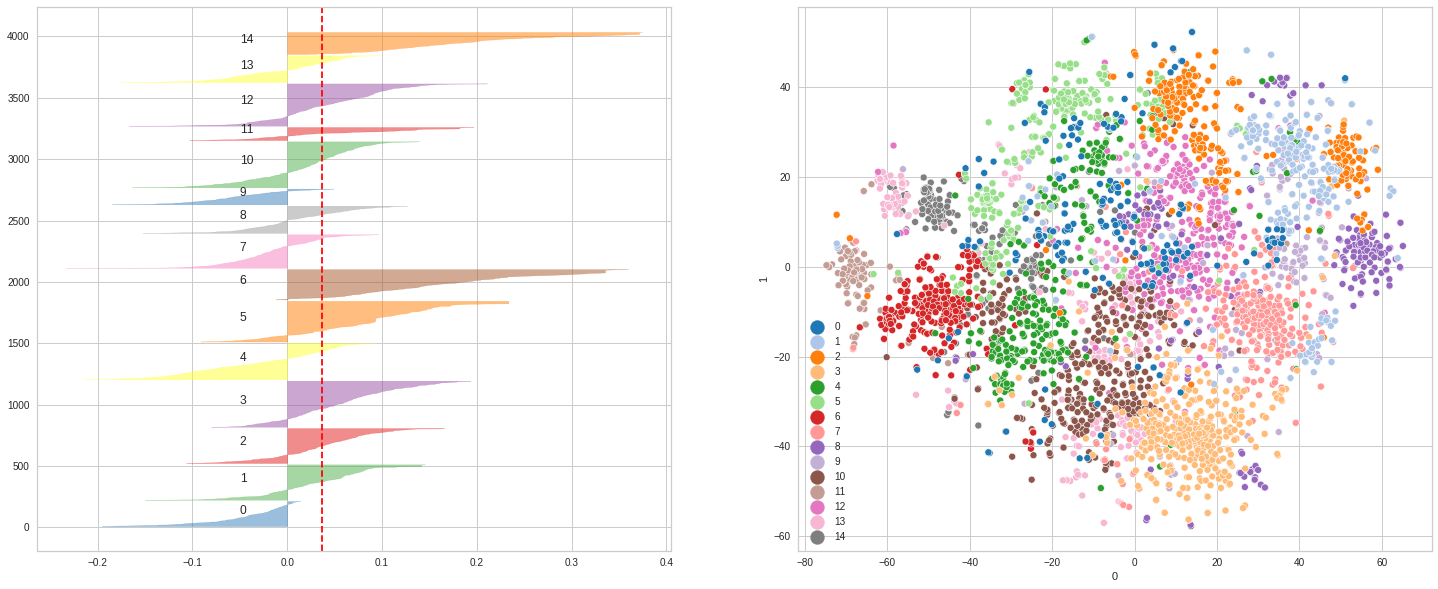

In [ ]:
# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'features_w4.pkl')

model = myKmeans(features=features, k=15)
top_words_by_cluster = plotKmeansResults(model, features, vocab, top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=50)


Cluster 0 - Top 50 most freq words:
------
END, what, a, how, there, which, where, many, hello, we, okay, yes, well, ok, hopefully, guy, 
sorry, alright, clear, anyone, morning, application, specifically, language, real, anybody, marie, state, harry, surface, spaghetti, 
breeder, uh, stamp, wish, choice, basically, base, shake, kid, carbohydrate, whose, invert, subtitle, colour, bubble, 
sam, afternoon, pain, callendar, 

Cluster 1 - Top 50 most freq words:
------
thank, day, storm, advance, together, vinegar, bye, testing, es, rain, foot, que, cheddar, crash, example, thanks, 
conditioning, merry, inaudible, speak, equal, shut, vibrate, forward, normally, chance, spanish, comma, delete, fahrenheit, assistance, 
fit, watt, later, camp, public, ios, task, garden, stormy, guest, live, esto, whoop, supreme, accessible, 
bring, bike, pertinent, glucose, 

Cluster 2 - Top 50 most freq words:
------
up, something, black, down, white, blue, regular, conditioner, line, dark, upside, salt, eit

#### Features with Triplets of Dependency

Counter({0: 3857, 28: 1, 3: 1, 17: 1, 25: 1, 21: 1, 18: 1, 19: 1, 6: 1, 27: 1, 12: 1, 26: 1, 1: 1, 20: 1, 10: 1, 24: 1, 29: 1, 2: 1, 8: 1, 7: 1, 14: 1, 4: 1, 16: 1, 11: 1, 23: 1, 9: 1, 15: 1, 5: 1, 13: 1, 22: 1})


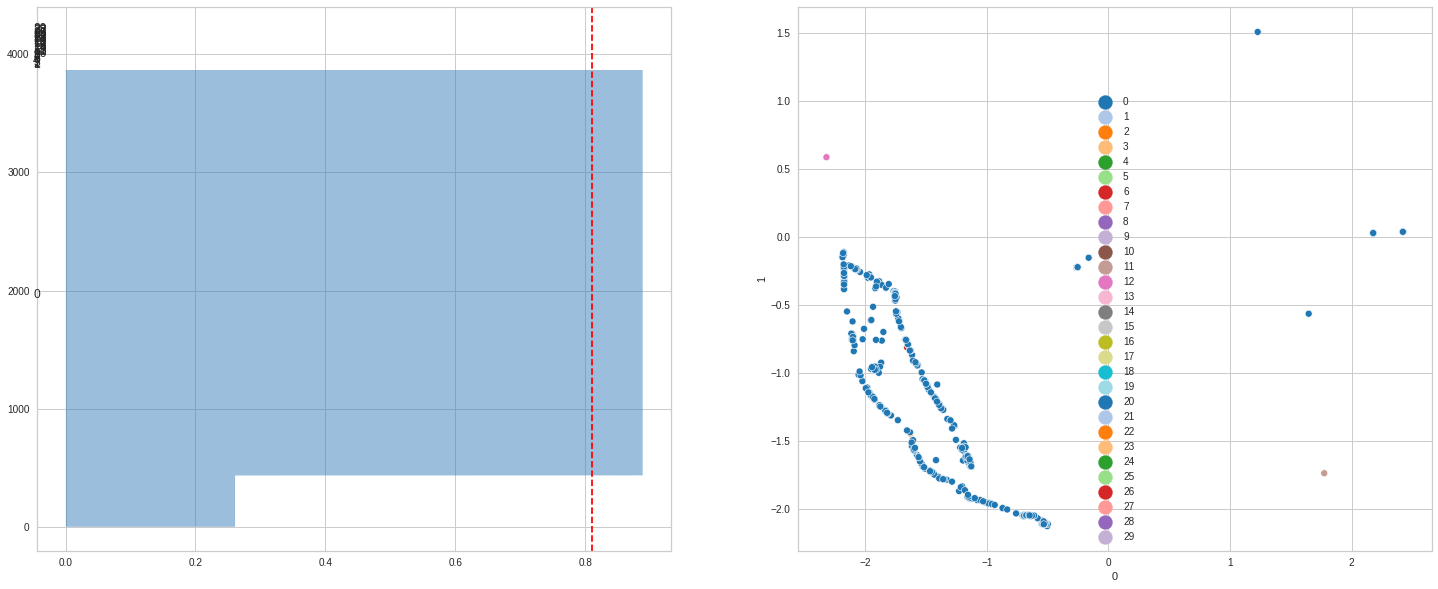

In [ ]:
def dropSpecialTokens(vocab):
    "Delete INIT and END tokens in vocab"

    # Delete INIT and END token in vocab
    vocab = vocab.drop(0)
    vocab = vocab.drop(1)
    vocab = vocab.reset_index(drop=True)
    return vocab

# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'features_triplas.pkl')

model = myKmeans(features=features, k=30)
top_words_by_cluster = plotKmeansResults(model, features, dropSpecialTokens(vocab), top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=50)


Cluster 0 - Top 50 most freq words:
------
be, what, this, the, of, i, you, can, in, do, it, tell, please, kind, thank, say, 
a, to, and, that, or, these, picture, my, box, shirt, screen, how, bottle, if, flavor, 
see, for, product, there, know, item, name, have, not, type, could, number, look, label, which, 
read, like, one, brand, 

Cluster 1 - Top 50 most freq words:
------
diet, 

Cluster 2 - Top 50 most freq words:
------
part, 

Cluster 3 - Top 50 most freq words:
------
security, 

Cluster 4 - Top 50 most freq words:
------
color, 

Cluster 5 - Top 50 most freq words:
------
cd, 

Cluster 6 - Top 50 most freq words:
------
fruit, 

Cluster 7 - Top 50 most freq words:
------
fish, 

Cluster 8 - Top 50 most freq words:
------
air, 

Cluster 9 - Top 50 most freq words:
------
cheese, 

Cluster 10 - Top 50 most freq words:
------
so, 

Cluster 11 - Top 50 most freq words:
------
vinegar, 

Cluster 12 - Top 50 most freq words:
------
advance, 

Cluster 13 - Top 50 most freq words:
-

### Results using Neuronal Word Embedding

##### WINDOW_SIZE=1, Number of features=100

Counter({15: 514, 16: 365, 0: 296, 3: 289, 17: 266, 4: 237, 11: 175, 2: 161, 7: 150, 5: 124, 19: 92, 10: 79, 13: 59, 18: 57, 12: 49, 6: 47, 14: 46, 9: 28, 1: 21, 8: 21})


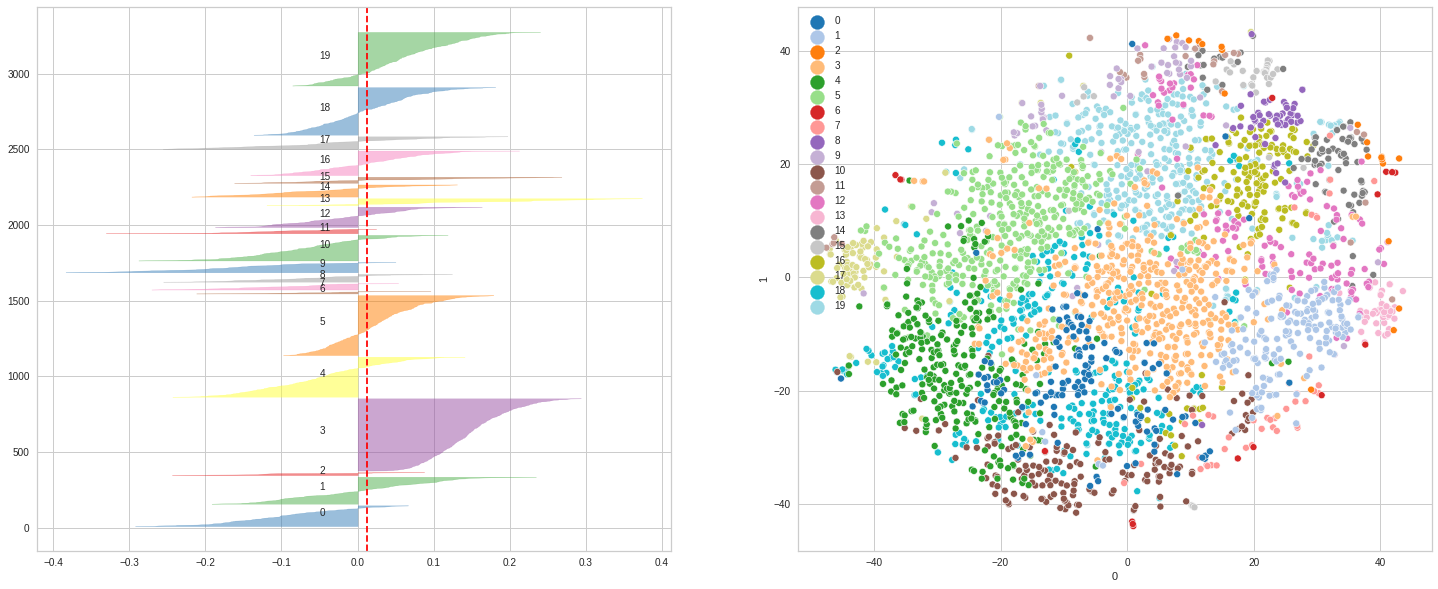

In [ ]:
# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'word2vec_w1_v100.pkl')

model = myKmeans(features=features, k=20)
top_words_by_cluster = plotKmeansResults(model, features, vocab, top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=50)


Cluster 0 - Top 50 most freq words:
------
do, color, picture, have, not, label, need, time, temperature, instruction, now, top, left, we, thing, okay, 
model, will, wine, all, hand, answer, dvd, your, logo, regular, send, message, bottom, dark, dial, 
figure, big, yarn, floor, person, new, fan, k, either, envelope, face, animal, sheet, specific, enough, 
pair, scale, disk, sound, 

Cluster 1 - Top 50 most freq words:
------
here, page, drink, piece, pill, meat, chocolate, its, oh, skirt, also, fabric, great, else, mix, advance, 
curtain, dirty, eye, material, gold, around, album, application, stuff, heavy, router, baseball, vinegar, modem, plate, 
wrap, area, garment, needle, fax, correct, recorder, end, reader, circle, desk, scanner, jello, state, jewelry, 
panel, least, d, seven, 

Cluster 2 - Top 50 most freq words:
------
a, to, name, type, number, brand, card, expiration, so, take, they, up, photo, image, light, go, 
two, want, oven, good, thermostat, turn, back, record, key, ok

##### WINDOW_SIZE=5, Number of features=100

Counter({13: 595, 8: 428, 19: 400, 4: 365, 1: 330, 10: 310, 6: 234, 15: 222, 11: 132, 7: 111, 17: 106, 18: 98, 2: 98, 9: 88, 12: 73, 3: 70, 14: 68, 0: 59, 5: 58, 16: 43})


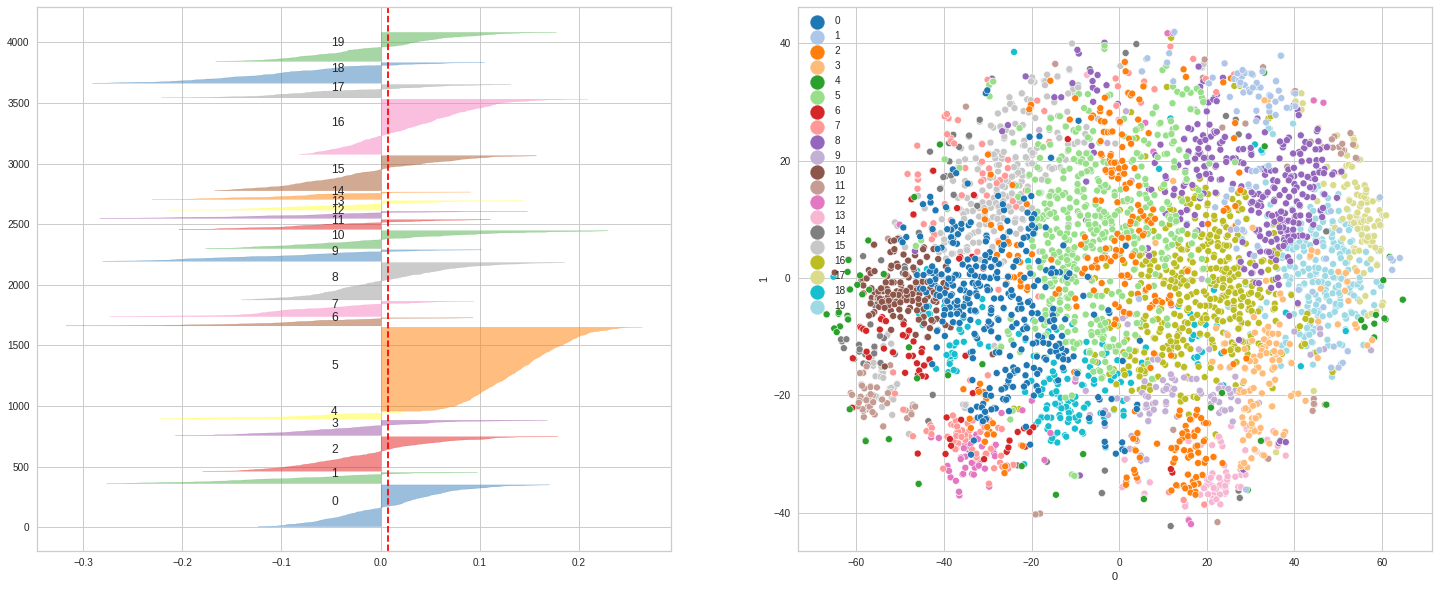

In [ ]:
# Cargo palabras vectorizadas (features)
features = pd.read_pickle(DF_FOLDER+'word2vec_w5_v100.pkl')

model = myKmeans(features=features, k=20)
top_words_by_cluster = plotKmeansResults(model, features, vocab, top_words=500)

In [ ]:
printWordByCluster(model, top_words_by_cluster, top=50)


Cluster 0 - Top 50 most freq words:
------
thank, show, captcha, phone, medicine, some, container, content, its, description, tin, call, photograph, contain, serial, put, 
chair, place, headphone, before, day, detail, anyone, tie, stain, mix, decaf, advance, pack, material, seem, 
press, street, gold, potato, pregnancy, tomato, cigarette, trouser, second, website, service, detergent, password, mug, cloth, 
guess, pudding, ground, plate, 

Cluster 1 - Top 50 most freq words:
------
picture, box, there, know, right, any, title, thing, wine, well, bar, over, denomination, hat, diet, away, 
kitchen, jack, merry, instant, contact, effect, blackberry, screw, tall, request, setup, wart, gross, rely, hallway, 
pringle, koolaid, lawry, plaid, cot, transformer, inconvenience, drape, max, trainer, docket, hotspot, invitation, kim, san, 
arrowhead, classify, nutter, chase, 

Cluster 2 - Top 50 most freq words:
------
and, name, date, go, an, front, use, possible, ok, money, someone, way, monitor,